* [Long Story Generator (Full Project) @ Git]() 

# **1. Prompt to Synopsis Generator** (Fine-Tuning) 

### **Summary** 

##### Train a `Synopsis Generator` model by `Fine-Tuning` a pre-trained model to generate `Synopsis` using `Prompts`. 

![Image](https://th.bing.com/th/id/R.62fed4c6ba6af08871ed40c89f4d0a44?rik=bHeTpfghWffTSQ&riu=http%3a%2f%2fsusancushman.com%2fwp-content%2fuploads%2f2012%2f10%2f100_12691.jpg&ehk=u%2fiowcjKxXZcabvS21Q2ExLG0g6YsIK6vJcgkcE7Xxc%3d&risl=&pid=ImgRaw&r=0)

'''

#### **Process** 

* [1. Preparing Dataset](#1)
* [2. Training Model](#2)
* [3. Benchmarking](#5)

***
***

## **a. Preparing Dataset** <a id="1"></a>

### **Summary** 

* Here, we will prepare a Dataset that contains **`High Quality Synopsis`** `(Training Data)` and **`Prompts`** `(Labels)` consisting of **`Elements`** that describe the **`Synopsis`** and help the model establish better **`relation`** between the given **`Prompts`** and the **`Synopsis`** to be generated.

'''

### **Dataset**
* For this purpose we will use the following Dataset - 
    * [MPST: Movie Plot Synopses with Tags Dataset](https://www.kaggle.com/datasets/cryptexcode/mpst-movie-plot-synopses-with-tags) from [Kaggle](https://www.kaggle.com/) 
* Download the Dataset from the [link](https://www.kaggle.com/datasets/cryptexcode/mpst-movie-plot-synopses-with-tags) and read it as shown below.

In [1]:
import numpy as np 
import pandas as pd  

df = pd.read_csv("./Dataset/mpst_full_data.csv")

print(df.shape)
df.head()

(14828, 6)


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


**Notes:**
* The Dataset consists of **`plot_synopsis`** which will be our `Training Data`. 
* It also consists of **`title`** and **`tags`** which will be used in creating **`Prompts`**.

'''

### **Process**

* We will prepare our Dataset in following 5 Steps - 

1. `Shorten the Synopsis` 
2. `Generate Context` 
3. `List and Categorize Tags` 
4. `Generate Prompts`  


##### **1. `Shorten the Synopsis`** 

* We want our model to `generate synopsis` of `similar length` each time. 
* But as we can see below the `Synopsis length` is all over the place. (click the image to expand it) 

In [2]:
import math
import matplotlib.pyplot as plt


for i, row in df.iterrows():
    df.loc[i, "length"]=len(row["plot_synopsis"].split())

df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,length
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,1315.0
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,378.0
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,707.0
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,2317.0
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb,3063.0


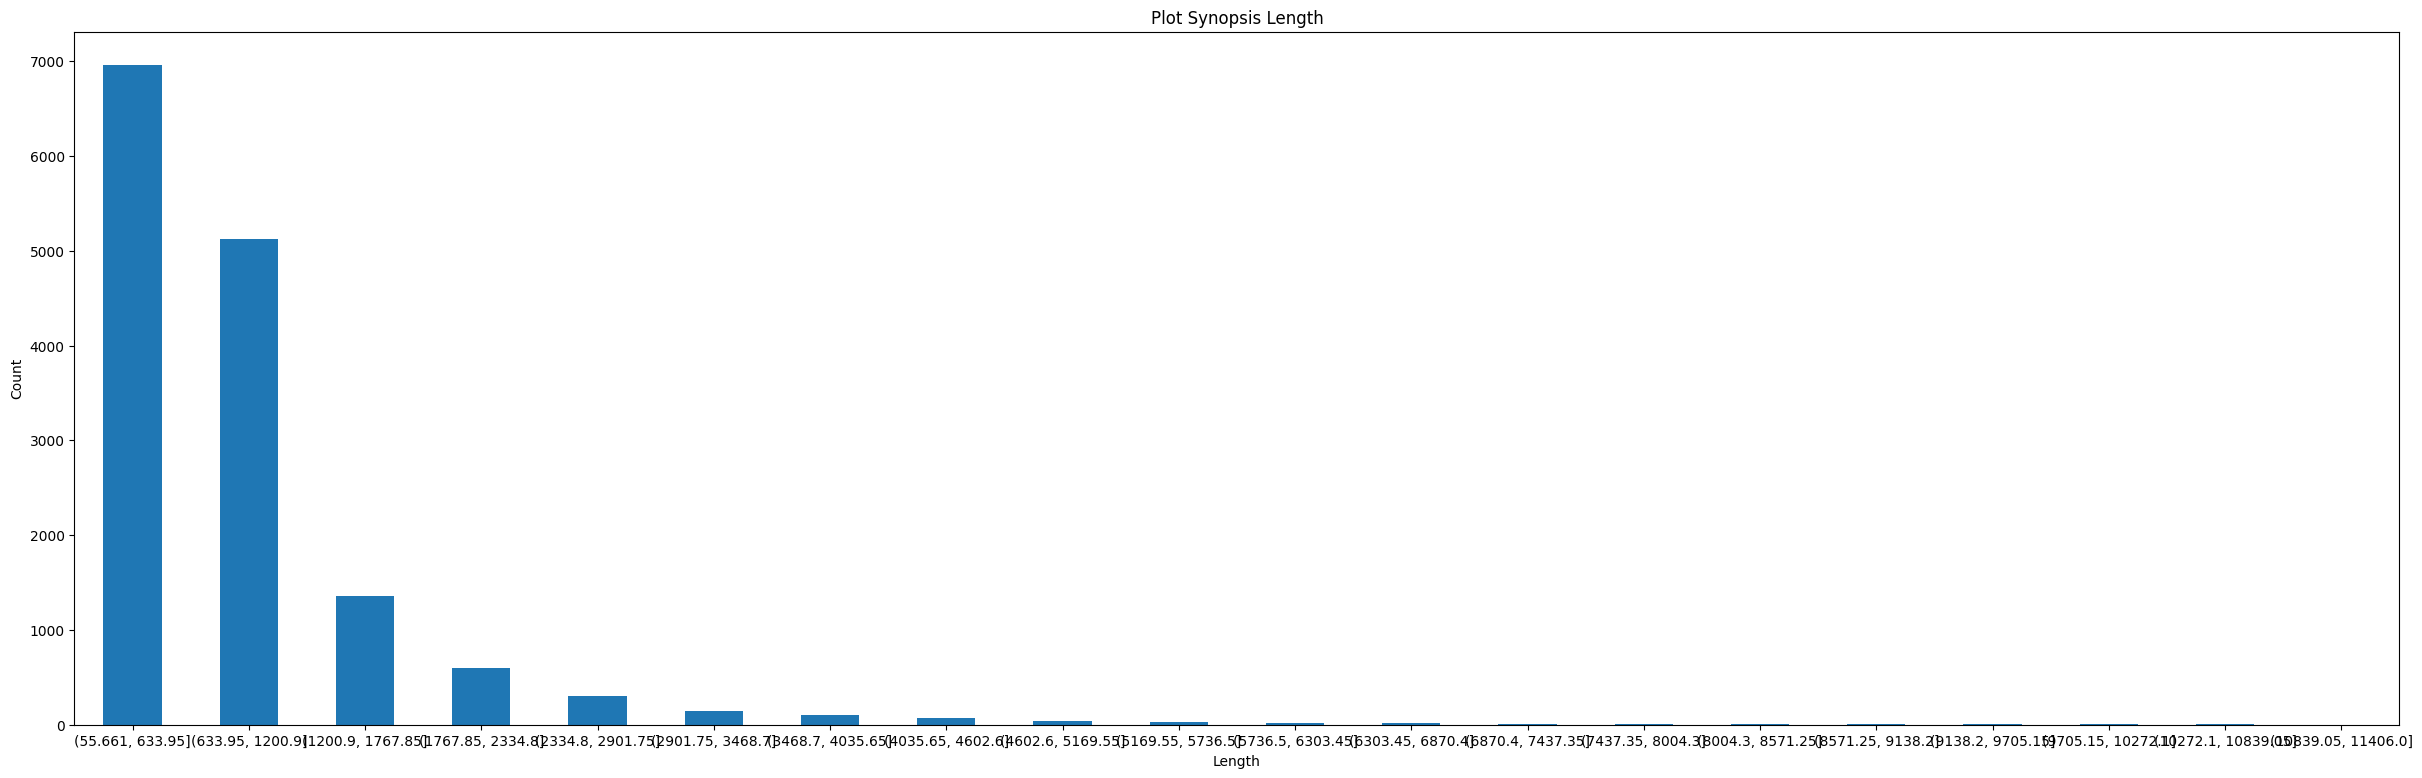

In [3]:
plt.figure(figsize=(30,9))
pd.cut(df["length"], bins=20).value_counts(sort=False).plot.bar(rot=0)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Plot Synopsis Length")
plt.show()

* According to the graph, most `synopsis` are under the length of `1200 words` but some are extremely large (more than `10000 words`). 
* We need to `restrict` the `length` of the plot synopis. As to why, because - 
1. **`Model Limitations`** - 
    * We will be using a `smaller model` for our synopsis generator. 
    * And maintaining `context` and `coherence` across `small` blocks of generated text is easier. 
    * Shorter `Training Data` will also `speed` up the `Training` process. 
2. **`Practical Use`** - 
    * We will be using the `plot synopsis` only as a `general direction` for the `Story Generator` model rather than a strict path to follow. 
    * So a `short summary` of the plot synopsis with the most `important parts extracted` will be enough to fulfill this role.

* Let's set the ``min length`` to `150 words` restrict the `max length` to `1000 words`. 

In [4]:
for i, row in df.iterrows():
    if row["length"]<1001:
        if row["length"]<151: df.drop(i, axis=0, inplace=True) 
        else: pass
    else: df.loc[i,"plot_synopsis"]=" ".join(row["plot_synopsis"].split()[:1000])

# Dropping irrelevant columns
df.drop(["length", "synopsis_source", "split", "imdb_id"], axis=1, inplace=True)

print(df.shape)
df.head()

(14785, 3)


,title,plot_synopsis,tags
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric"
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good"
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm..."


##### **2. `Generate Context`** 

* `Context` is another `input` that we will take from the `User`. This will help the model understand more about the User preference for `generating story`.
* To create `Context`, we will simply use `Abstractive Summarization` over the `plot_synopsis`.  
* We use a Pre-trained Model [google/pegasus-xsum](https://huggingface.co/google/pegasus-xsum) from [HuggingFace](https://huggingface.co/) for this purpose. 

In [5]:
from transformers import pipeline
from IPython.display import clear_output

summarizer = pipeline("summarization", model="google/pegasus-xsum")

print("Summary: " + summarizer(df.iloc[0,1][:2000], max_length=51, min_length=5, do_sample=False)[0].get("summary_text"))


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Summary: Three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.


* As this `Dataset` is too `big`, generating context this way will take very-very long.
* So we will `divide` the dataset into `4 parts`, `generate context` for each of them, and then `concatenate` them into one dataset.

##### **Context Generation - Part 1**

In [10]:
mpst_1 = df[:4000]
counter=0

for i, row in mpst_1.iterrows():
    try: mpst_1.loc[i, "context"]=summarizer(row["plot_synopsis"][:2000], 
                                        max_length=51, min_length=5, 
                                        do_sample=False)[0].get("summary_text")
    except: mpst_1.loc[i, "context"]=""
    counter+=1
    clear_output()
    print(counter/mpst_1.shape[0])

mpst_1.head()

1.0


,title,plot_synopsis,tags,context
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",Three horror tales of the macabre and the supe...
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,The Book of Vile Darkness is the story of a so...
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,A romantic comedy set in a department store in...
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",In our series of letters from African-American...
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",Oscar-winning actor Al Pacino stars as Tony Mo...


In [11]:
mpst_1.to_csv("./Dataset/mpst_1.csv", index=False)

##### **Context Generation - Part 2**

In [12]:
mpst_2 = df[4000:8000]
counter=0

for i, row in mpst_2.iterrows():
    try: mpst_2.loc[i, "context"]=summarizer(row["plot_synopsis"][:2000], 
                                        max_length=51, min_length=5, 
                                        do_sample=False)[0].get("summary_text")
    except: mpst_2.loc[i, "context"]=""
    counter+=1
    clear_output()
    print(counter/mpst_2.shape[0])

mpst_2.head()

1.0


,title,plot_synopsis,tags,context
0,The Black Sleep,The picture opens with narration over a black ...,insanity,Basil Rathbone's film Nind Andhera is based on...
1,Spun,Ross (Jason Schwartzman) is a regular customer...,"pornographic, boring, entertaining",Based on the best-selling novel of the same na...
2,Tale of a Vampire,Alex [Julian Sands] is a vampire but he drinks...,violence,Based on the novel of the same name by Stephen...
3,Dark Night of the Scarecrow,"In a small nameless town in the Deep South, ""B...","cult, revenge, cruelty, murder, violence",A vigilante drama set in the South in the 1960...
4,Hitch,The movie opens with Alex Hitchens (Will Smith...,"comedy, boring, cute, humor, romantic, enterta...","Will Smith's latest movie ""Hitch"" tells the st..."


In [7]:
mpst_2.to_csv("./Dataset/mpst_2.csv", index=False)

##### **Context Generation - Part 3**

In [11]:
mpst_3 = df[8000:12000]
counter=0

for i, row in mpst_3.iterrows():
    try: mpst_3.loc[i, "context"]=summarizer(row["plot_synopsis"][:2000], 
                                        max_length=51, min_length=5, 
                                        do_sample=False)[0].get("summary_text")
    except: mpst_3.loc[i, "context"]=""
    counter+=1
    clear_output()
    print(counter/mpst_3.shape[0])

mpst_3.head()

1.0


,title,plot_synopsis,tags,context
8025,The Killer Is Loose,An employee of a savings and loan company succ...,"revenge, murder",The story of a bank robber who goes on the run...
8026,Antiviral,"In a dystopian near-future, Syd March (Caleb L...","psychedelic, satire",A thriller set in a dystopian future in which ...
8027,Next,Cris Johnson (Nicolas Cage) can see into his f...,psychedelic,A magician's ability to see into the future is...
8028,Miss Potter,The story begins with Beatrix Potter nervously...,"fantasy, storytelling, flashback","Beatrix Potter's first book, The Tale of Beatr..."
8029,Shurayukihime,The scenes of this film do not appear in chron...,"murder, cult, violence, flashback, good versus...","The story of Shura Yuki-hime, the woman who ki..."


In [12]:
mpst_3.to_csv("./Dataset/mpst_3.csv", index=False)

##### **Context Generation - Part 4**

In [6]:
mpst_4 = df[12000:]
counter=0

for i, row in mpst_4.iterrows():
    try: mpst_4.loc[i, "context"]=summarizer(row["plot_synopsis"][:2000], 
                                        max_length=51, min_length=5, 
                                        do_sample=False)[0].get("summary_text")
    except: mpst_4.loc[i, "context"]=""
    counter+=1
    clear_output()
    print(counter/mpst_4.shape[0])

mpst_4.head()

1.0


,title,plot_synopsis,tags,context
12036,Doragon bôru Z: Tatta hitori no saishû kessen ...,Dragon Ball Z picks up five years after the en...,"tragedy, violence",Dragon Ball Z is the fifth anime in the Dragon...
12037,Broken Trail,"Part 1 In San Francisco in 1898, countless Chi...","romantic, murder",A Western set in the American West in the earl...
12038,The Jetsons Meet the Flintstones,"In the future, while Elroy is busy working on ...",alternate history,"In the Stone Age, Fred and Barney are trying t..."
12039,Captain Barbell,"In every version of the story, major changes i...",good versus evil,Captain Barbell is one of the most popular sup...
12040,Ying hung boon sik,"Sung Tse-Ho (Ti Lung) works for the Triad, who...","comedy, cruelty, murder, violence, cult, flash...",The film tells the story of a high-ranking mem...


In [7]:
mpst_4.to_csv("./Dataset/mpst_4.csv", index=False)

##### **Concatenating all 4 Parts**

In [1]:
import pandas as pd

mpst_1=pd.read_csv("./Dataset/mpst_1.csv")
mpst_2=pd.read_csv("./Dataset/mpst_2.csv")
mpst_3=pd.read_csv("./Dataset/mpst_3.csv")
mpst_4=pd.read_csv("./Dataset/mpst_4.csv")

mpst=pd.concat([mpst_1, mpst_2, mpst_3, mpst_4], ignore_index=True)

print(mpst.shape)
mpst.head()

(14785, 4)


,title,plot_synopsis,tags,context
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",Three horror tales of the macabre and the supe...
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,The Book of Vile Darkness is the story of a so...
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,A romantic comedy set in a department store in...
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",In our series of letters from African-American...
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",Oscar-winning actor Al Pacino stars as Tony Mo...


##### **Removing null values in Context**

In [2]:
for i, row in mpst.iterrows():
    if row["context"]=="" or row["context"]==None: df.drop(i, axis=0, inplace=True)

print(mpst.shape)

(14785, 4)


In [3]:
mpst.to_csv("./Dataset/mpst.csv", index=False)

##### **3. `List and Categorize Tags`** 

* In this dataset, we have a column named `tags` which contains various tags that describe the Genre, Style, Tone, Mood and Theme of the Synopsis.
* Here, we will make a list of all the unique tags used in the dataset.
* Then, we will also divide the list into 5 sub-list of Genre, Style, Tone, Mood and Theme.
* This will be done to make it easier for us to locate the tags and implement the User Input in App UI.

In [1]:
import pandas as pd 

df=pd.read_csv("./Dataset/mpst.csv")

print(df.shape)
df.head()

(14785, 4)


,title,plot_synopsis,tags,context
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",Three horror tales of the macabre and the supe...
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,The Book of Vile Darkness is the story of a so...
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,A romantic comedy set in a department store in...
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",In our series of letters from African-American...
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",Oscar-winning actor Al Pacino stars as Tony Mo...


In [2]:
tags_column = df.iloc[:, 2].to_list() 
for i in range(len(tags_column)):
    tags_column[i] = tags_column[i].split(", ")

tags_list=list() 
for sublist in tags_column:
    for string in sublist:
        tags_list.append(string)

tags=set(tags_list)
tags=sorted(list(tags))

print(len(tags))
print(tags)

71
['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war', 'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic', 'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction', 'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']


In [3]:
tags=['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 
'anti war', 'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 
'brainwashing', 'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 
'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 
'good versus evil', 'gothic', 'grindhouse film', 'haunting', 'historical', 'historical fiction', 
'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magical realism', 'melodrama', 
'murder', 'mystery', 'neo noir', 'non fiction', 'paranormal', 'philosophical', 'plot twist', 
'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 
'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 
'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']

print(len(tags)) 

71


In [4]:
genre=['action', 'adult comedy', 'alternate history', 'alternate reality', 'blaxploitation', 
        'christian film', 'horror', 'mystery', 'non fiction', 'paranormal', 'pornographic', 
        'sci-fi', 'western']
style=['avant garde', 'boring', 'grindhouse film', 'humor', 'insanity', 'intrigue', 'magical realism', 
        'melodrama', 'murder', 'neo noir', 'plot twist', 'psychedelic', 'queer', 'realism', 'satire', 
        'sentimental', 'storytelling']
tone=['absurd', 'allegory', 'anti war', 'autobiographical', 'bleak', 'brainwashing', 'dark', 'depressing', 
      'dramatic', 'entertaining', 'feel-good', 'historical fiction', 'inspiring', 'thought-provoking', 
      'whimsical']
mood=['atmospheric', 'claustrophobic', 'haunting', 'historical', 'home movie', 'philosophical', 'prank', 
      'psychological', 'sadist', 'stupid', 'suspenseful', 'violence']
theme=['clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'fantasy', 'flashback', 'good versus evil', 
       'gothic', 'revenge', 'romantic', 'suicidal', 'tragedy']

##### **4. `Generating Prompts`** 

* Finally, we will take the labels we have namely - Title, tags, and Context to form a single label named Prompts.

In [5]:
def prompt_generator_per_row(title, context, tags): 
    prompt=(f"Generate a Synopsis titled:- {title}. " + 
            f"Context: {context} " + 
            f"Tags: {tags}.")
    return prompt

In [6]:
for i, row in df.iterrows():
    df.loc[i, "prompt"]=prompt_generator_per_row(title=row["title"], 
                                                 context=row["context"], 
                                                 tags=row["tags"]) 

df.head()

,title,plot_synopsis,tags,context,prompt
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",Three horror tales of the macabre and the supe...,Generate a Synopsis titled:- I tre volti della...
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,The Book of Vile Darkness is the story of a so...,Generate a Synopsis titled:- Dungeons & Dragon...
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,A romantic comedy set in a department store in...,Generate a Synopsis titled:- The Shop Around t...
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",In our series of letters from African-American...,Generate a Synopsis titled:- Mr. Holland's Opu...
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",Oscar-winning actor Al Pacino stars as Tony Mo...,Generate a Synopsis titled:- Scarface. Context...


In [10]:
df.iloc[59,4]

'Generate a Synopsis titled:- The Men Who Stare at Goats. Context: Based on the best-selling novel of the same name by Dave Eggers and directed by Eggers himself, The Heartbreak Kid is a comedy about a newspaper reporter who decides to go to Iraq in order to get the perfect scoop. Tags: comedy, boring, historical fiction, flashback, absurd, humor, satire.'

##### **5. `Dropping irrelevant columns`** 

* Keeping only our Training Data `plot_synopsis` and label `prompt`, we will drop rest of the columns.

In [14]:
df.drop(["title", "context", "tags"], axis=1, inplace=True) 

print(df.shape)
df.head()

(14785, 2)


,plot_synopsis,prompt
0,Note: this synopsis is for the orginal Italian...,Generate a Synopsis titled:- I tre volti della...
1,"Two thousand years ago, Nhagruul the Foul, a s...",Generate a Synopsis titled:- Dungeons & Dragon...
2,"Matuschek's, a gift store in Budapest, is the ...",Generate a Synopsis titled:- The Shop Around t...
3,"Glenn Holland, not a morning person by anyone'...",Generate a Synopsis titled:- Mr. Holland's Opu...
4,"In May 1980, a Cuban man named Tony Montana (A...",Generate a Synopsis titled:- Scarface. Context...


In [13]:
df.to_csv("./Dataset/mpst.csv", index=False)

***
***

## **2. Training Model** <a id="2"></a> 

* Now, in this section we will `fine tune` a pretrained model named [google/flan-t5-base](https://huggingface.co/google/flan-t5-base) from an AI platform called [Huggingface](https://huggingface.co).
* `FLAN-T5` is an enhanced version of the `T5` model that has been `fine-tuned` on a mixture of tasks. 
* It’s an `encoder-decoder` model pre-trained on various language tasks, with the goal of learning mappings between sequences of text, i.e., text-to-text. 
* [google/flan-t5-base](https://huggingface.co/google/flan-t5-base) has `248 million` parameters.


#### **Inference**

* Below we load the `model` and `tokenizer` of the model and generate a story using a prompt.

In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-small')
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-small')

2023-09-19 20:02:24.481135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 20:02:25.049321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [2]:
def generate_story(prompt):
    inputs = tokenizer.encode("story: " + prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs, max_length=300, min_length=100, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0])

story = generate_story("Write a story of a sandwich in space with a cute teddy bear as a vilain.")
print(f"Story: {story}")

Story: <pad> A teddy bear is a cute teddy bear. It's a cute teddy bear with a cute teddy bear as a vilain. A teddy bear is a cute teddy bear with a cute teddy bear as a vilain. A teddy bear is a cute teddy bear with a cute teddy bear as a vilain. A teddy bear is a cute teddy bear as a vilain.</s>


### **Preparing Dataset**

* Here, we will prepare our dataset to be trainable with our model. 
* The code reads a `CSV` file into a DataFrame, `tokenizes` and prepares the input and output sequences for a text-to-text task, and creates a custom `PyTorch Dataset` with these sequences. 

##### **`Importing Dataset`**

In [2]:
import pandas as pd

df=pd.read_csv("./Dataset/mpst.csv")
print(df.shape)
df.head()

(14785, 2)


,plot_synopsis,prompt
0,Note: this synopsis is for the orginal Italian...,Generate a Synopsis titled:- I tre volti della...
1,"Two thousand years ago, Nhagruul the Foul, a s...",Generate a Synopsis titled:- Dungeons & Dragon...
2,"Matuschek's, a gift store in Budapest, is the ...",Generate a Synopsis titled:- The Shop Around t...
3,"Glenn Holland, not a morning person by anyone'...",Generate a Synopsis titled:- Mr. Holland's Opu...
4,"In May 1980, a Cuban man named Tony Montana (A...",Generate a Synopsis titled:- Scarface. Context...


##### **`Inputs_Ids and Labels`**

* This code `tokenizes` and `encodes` input and output sequences from a DataFrame, adds a task-specific `prefix` to the inputs, and sets specific `lengths` for the sequences. 
* `Padding` tokens in the output labels are replaced with -100 to avoid computing loss for them.

In [3]:
max_source_length = 512
max_target_length = 256
task_prefix = "synopsis"



input_sequences = df.iloc[:, 1].to_list() 

encoding = tokenizer(
    [task_prefix + sequence for sequence in input_sequences],
    padding = "longest",
    max_length = max_source_length,
    truncation = True,
    return_tensors = "pt",
)
input_ids, attention_mask = encoding.input_ids, encoding.attention_mask



output_sequences = df.iloc[:, 0].to_list() 

target_encoding = tokenizer(
    output_sequences,
    padding = "longest",
    max_length = max_target_length,
    truncation = True,
    return_tensors = "pt",
)
labels = target_encoding.input_ids
labels[labels == tokenizer.pad_token_id] = -100

* This code defines a custom `PyTorch Dataset` and converts input encodings and labels into `PyTorch tensors`. 
* The Dataset retrieves tensorized `input-label pairs` and provides the dataset `length`.

In [4]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
input_ids = torch.tensor(input_ids.numpy())
attention_mask = torch.tensor(attention_mask.numpy())
labels = torch.tensor(labels.numpy())

In [6]:
dataset = CustomDataset({'input_ids': input_ids, 'attention_mask': attention_mask}, labels)

### **Fine-Tuning the Model**

* In this code we set up and start a `training` process for our Hugging Face model. 
* Here we define the training arguments like `epochs`, `batch size`, `warmup steps`, `weight decay`, and output directories. 
* Then, we create a `Trainer` with the model, arguments, and dataset, and initiates training.

In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

In [9]:
from transformers import Trainer

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset,               # training dataset
)

In [10]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptasanskar551. Use `wandb login --relogin` to force relogin


/tmp/ipykernel_49233/867408961.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_49233/867408961.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss
500,3.626000
1000,3.555400
1500,3.524700
2000,3.509800
2500,3.499400


/tmp/ipykernel_49233/867408961.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_49233/867408961.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/tmp/ipykernel_49233/867408961.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_49233/867408961.py:11: UserWarning: To copy construct from a tensor, it is re

TrainOutput(global_step=2775, training_loss=3.537910574148367, metrics={'train_runtime': 6078.3827, 'train_samples_per_second': 7.297, 'train_steps_per_second': 0.457, 'total_flos': 5877906772838400.0, 'train_loss': 3.537910574148367, 'epoch': 3.0})

#### **Save Model**

In [12]:
import torch

# Assuming that 'model' is your trained model
torch.save(model.state_dict(), 'model.pth')

#### **Clear Session**

In [13]:
import gc

gc.collect()


40

#### **Load Model**

In [20]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-small')
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-small')
state_dict = torch.load('./model.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

#### **Prediction**

* In the code below, we `generate` a `story` based on a given title, context, and tags. 
* We first create a `prompt` using these inputs, `pre-process` it using the `tokenizer` just as before, then use our `fine-tuned` model to generate a `story` from the prompt.

In [21]:
def prompt_generator_per_row(title, context, tags): 
    prompt=(f"Generate a Synopsis titled:- {title}. " + 
            f"Context: {context} " + 
            f"Tags: {tags}.")
    return prompt

In [22]:
def generate_story(prompt):
    inputs = tokenizer.encode("story: " + prompt, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs, max_length=300, min_length=100, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0])

prompt=prompt_generator_per_row(title="A Space Sandwich", 
                                context="Story of a Heroic Sandwich who saved the world from a Cute but Evil Teddy Bear", 
                                tags="funny, cringe, action")
story = generate_story(prompt)
print(f"Story: {story}")

Story: <pad> The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story of a Heroic sandwich who saved the world from a Cute but Evil Teddy Bear. The story begins with the story o

***
***